Epoch 1/100


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: nan
Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: n

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
        date  predicted_heatwave heatwave
0 2022-07-26                   0       No
1 2022-07-27                   0       No
2 2022-07-28                   0       No
3 2022-07-29                   0       No
4 2022-07-30                   0       No


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


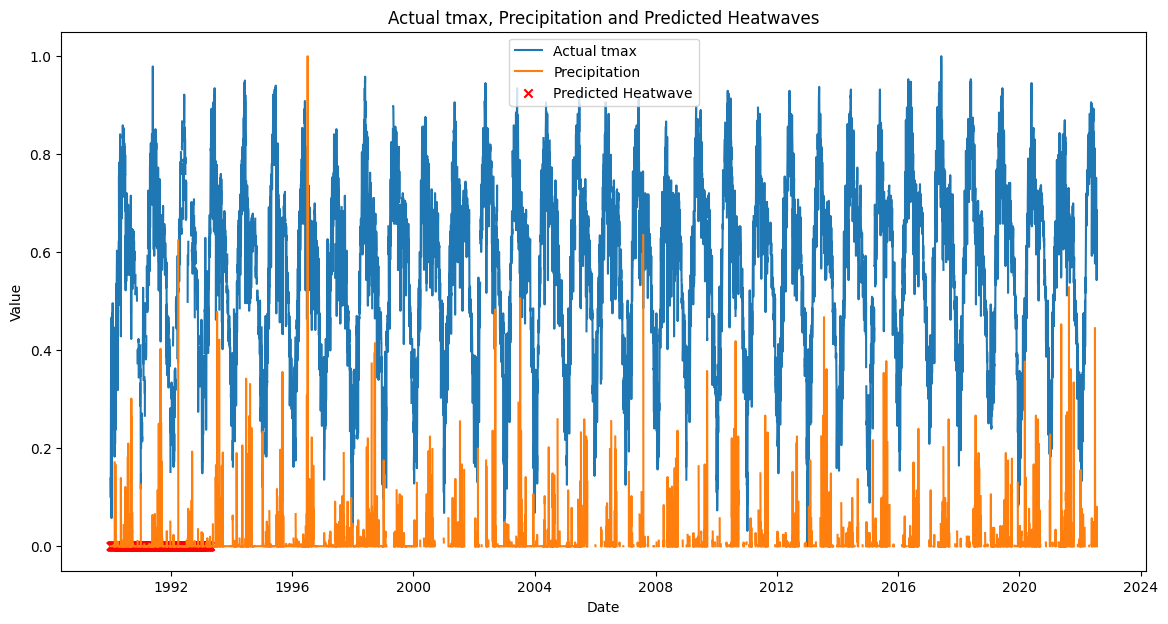

In [10]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = '12delhi.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5112 - loss: 0.8292 - val_accuracy: 1.0000 - val_loss: 0.6288
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.6288
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5144 - loss: 0.8403 - val_accuracy: 1.0000 - val_loss: 0.6198
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.6198
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5337 - loss: 0.8644 - val_accuracy: 1.0000 - val_loss: 0.6305
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.6304
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5388 - loss: 0.8407 - val_accuracy: 1.0000 - val_loss: 0.6145
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.6145
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5132 - loss: 0.8308 - val_accuracy: 1.0000 - val_loss: 0.6290
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.6290
Average Cross-Validation Accuracy: 100.00%
38/38 ━━━━━━

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
        date  predicted_heatwave heatwave
0 2022-07-26                   0       No
1 2022-07-27                   0       No
2 2022-07-28                   0       No
3 2022-07-29                   0       No
4 2022-07-30                   0       No


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


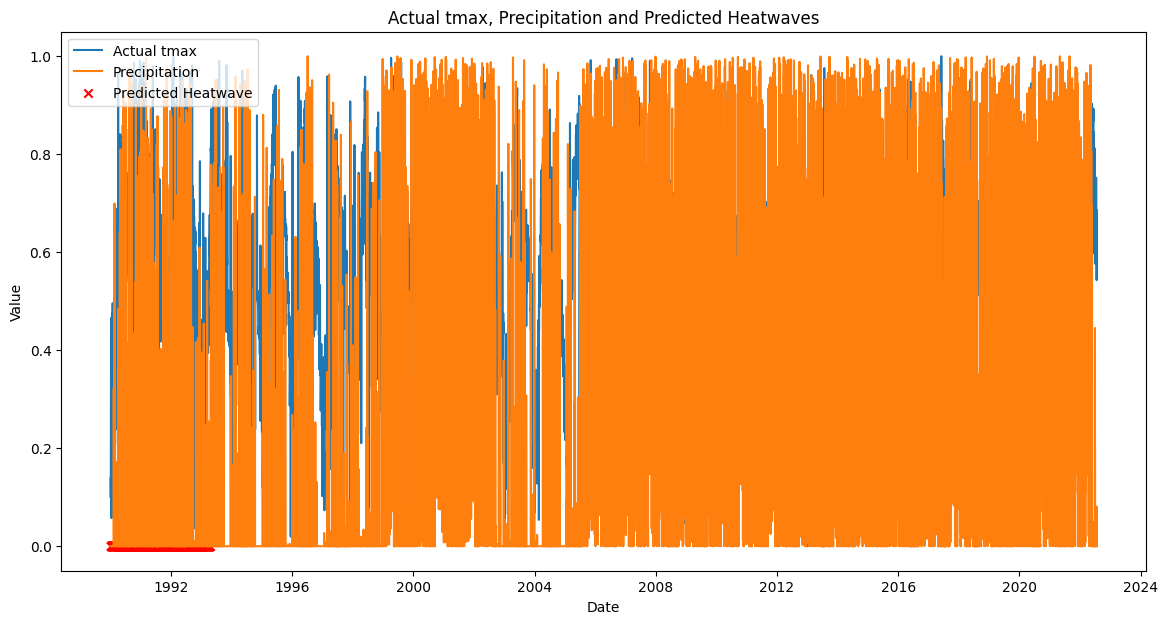

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data from a CSV file
file_path = '12delhi.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Function to fill NaNs with random values within the range of each column
def fill_na_randomly(df, columns):
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = df[column].apply(
            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
        )
    return df

# Fill NaNs with random values within the range of each column
data = fill_na_randomly(data, features)

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(Input(shape=(seq_length, len(features))))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=1, batch_size=500, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence with the new prediction (assuming the same range for tavg, tmin, tmax, prcp)
        new_entry = np.random.uniform(scaler.data_min_, scaler.data_max_, (1, len(features)))
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data from a CSV file
file_path = 'dc100.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Function to fill NaNs with random values within the range of each column
def fill_na_randomly(df, columns):
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = df[column].apply(
            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
        )
    return df

# Fill NaNs with random values within the range of each column
data = fill_na_randomly(data, features)

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=1, batch_size=100, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence with the new prediction (assuming the same range for tavg, tmin, tmax, prcp)
        new_entry = np.random.uniform(scaler.data_min_, scaler.data_max_, (1, len(features)))
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


KeyError: 'time'

In [1]:
import pandas as pd

# Load the dataset from a CSV file
df = pd.read_csv('delhi100.csv')

# Display the first few rows of the dataset to understand its structure
print(df.head())

# Fill missing values with appropriate defaults or calculated values
# For example, filling missing temperature values with the mean of available data
df['TAVG (Degrees Fahrenheit)'] = df['TAVG (Degrees Fahrenheit)'].fillna(df['TAVG (Degrees Fahrenheit)'].mean())
df['TMAX (Degrees Fahrenheit)'] = df['TMAX (Degrees Fahrenheit)'].fillna(df['TMAX (Degrees Fahrenheit)'].mean())
df['TMIN (Degrees Fahrenheit)'] = df['TMIN (Degrees Fahrenheit)'].fillna(df['TMIN (Degrees Fahrenheit)'].mean())
df['PRCP (Inches)'] = df['PRCP (Inches)'].fillna(0)  # Assuming 0 inches of precipitation where data is missing
df['SNOW (Inches)'] = df['SNOW (Inches)'].fillna(0)  # Assuming 0 inches of snow where data is missing
df['SNWD (Inches)'] = df['SNWD (Inches)'].fillna(0)  # Assuming 0 inches of snow depth where data is missing

# Save the cleaned dataset to a new CSV file
df.to_csv('dc100.csv', index=False)

# Print a message to indicate the process is complete
print("Dataset has been cleaned and saved to 'path_to_cleaned_dataset.csv'")


         Date  TAVG (Degrees Fahrenheit)  TMAX (Degrees Fahrenheit)  \
0  1901-01-01                        NaN                        NaN   
1  1901-01-02                        NaN                        NaN   
2  1901-01-03                        NaN                        NaN   
3  1901-01-04                        NaN                        NaN   
4  1901-01-05                        NaN                        NaN   

   TMIN (Degrees Fahrenheit)  PRCP (Inches)  SNOW (Inches)  SNWD (Inches)  
0                        NaN            0.0            NaN            NaN  
1                        NaN            0.0            NaN            NaN  
2                        NaN            0.0            NaN            NaN  
3                        NaN            0.0            NaN            NaN  
4                        NaN            0.0            NaN            NaN  
Dataset has been cleaned and saved to 'path_to_cleaned_dataset.csv'


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.4926 - loss: 0.8854 - val_accuracy: 1.0000 - val_loss: 0.6672
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.6672
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.4814 - loss: 0.8816 - val_accuracy: 1.0000 - val_loss: 0.6636
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.6636
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5205 - loss: 0.8931 - val_accuracy: 1.0000 - val_loss: 0.6613
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.6613
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.4940 - loss: 0.8603 - val_accuracy: 1.0000 - val_loss: 0.6629
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.6629
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.4746 - loss: 0.8760 - val_accuracy: 1.0000 - val_loss: 0.6672
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.6672
Average Cross-Validation Accuracy: 100.00%
131/131 ━━━━━━━━━

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
        date  predicted_heatwave heatwave
0 2022-07-26                   0       No
1 2022-07-27                   0       No
2 2022-07-28                   0       No
3 2022-07-29                   0       No
4 2022-07-30                   0       No


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


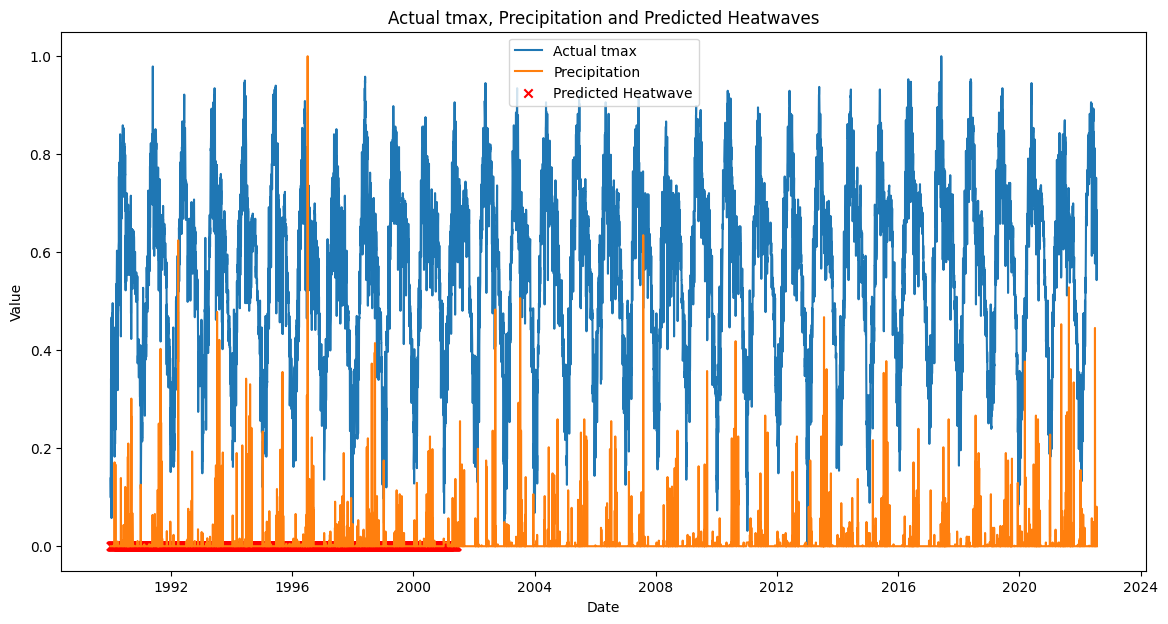

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data from a CSV file
file_path = '12delhi_cleaned.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Function to fill NaNs with random values within the range of each column
def fill_na_randomly(df, columns):
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = df[column].apply(
            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
        )
    return df

# Fill NaNs with random values within the range of each column
data = fill_na_randomly(data, features)

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=99, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=1, batch_size=100, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence with the new prediction (assuming the same range for tavg, tmin, tmax, prcp)
        new_entry = np.random.uniform(scaler.data_min_, scaler.data_max_, (1, len(features)))
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5685 - loss: 0.7358 - val_accuracy: 1.0000 - val_loss: 0.4351
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.4351 
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5841 - loss: 0.7947 - val_accuracy: 1.0000 - val_loss: 0.3238
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.3239 
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5728 - loss: 0.7523 - val_accuracy: 1.0000 - val_loss: 0.3864
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3864 
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5769 - loss: 0.7354 - val_accuracy: 1.0000 - val_loss: 0.4091
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.4091 
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5771 - loss: 0.7598 - val_accuracy: 1.0000 - val_loss: 0.3924
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.3925 
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5759 

Exception ignored in: <function AtomicFunction.__del__ at 0x0000019A13CD5DA0>
Traceback (most recent call last):
  File "C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py", line 300, in __del__
    RUNTIME_FUNCTION_REFS.pop(key)
KeyboardInterrupt: 


83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5799 - loss: 0.7678 - val_accuracy: 1.0000 - val_loss: 0.3458
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.3457 
44/83 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5277 - loss: 0.7653

In [13]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('delhi100.csv')

# Fill missing values using forward fill
df.fillna(method='ffill', inplace=True)

# Save the cleaned data to a new CSV file
df.to_csv('delhi100cleaned.csv', index=False)

print("Missing values handled and data saved to '12delhi_cleaned.csv'.")


Missing values handled and data saved to '12delhi_cleaned.csv'.


C:\Users\subbu\AppData\Local\Temp\ipykernel_7372\3478032114.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
